# Forecasting of daily River Discharge (RD) based on temperature and previous precipitation levels

### Import of libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
from sklearn import linear_model,preprocessing
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import math


### LoadingData

In [9]:
def loadData(river, daysBefore):
    data=pd.read_csv(river).values
    Xbefore = data[:,2:4]
    second_colum = Xbefore[:,1]
    second_colum = np.roll(second_colum,daysBefore)
    new_column = np.expand_dims(second_colum, axis=1)
    Xbefore = np.hstack((Xbefore, new_column))
    X = Xbefore[daysBefore:,:]
    y = data[daysBefore:,1]

    return X,y

### Prep of Data

In [10]:
def apply_boxcox(y):
    y_float64 = np.array(y, dtype=np.float64)
    res = boxcox(y_float64)
    y = res[0]
    lambda_val = res[1]
    return y, lambda_val

In [11]:
def preprocess_data(X, y, ):
    scaler = preprocessing.StandardScaler()
    poly_features = preprocessing.PolynomialFeatures(degree=2)

    X_trainN = X[:math.floor(len(X)*0.6)]
    y_train = y[:len(X_trainN)]

    remaining_time = len(X) - len(X_trainN)
    X_val = X[len(X_trainN):len(X_trainN)+(remaining_time//2)]
    y_val = y[len(X_trainN):len(X_trainN)+(remaining_time//2)]

    X_testN = X[len(X_trainN)+len(X_val):]
    y_test = y[len(X_trainN)+len(X_val):]

    X_train_poly = poly_features.fit_transform(X_trainN)
    X_val_poly = poly_features.transform(X_val)
    X_test_poly = poly_features.transform(X_testN)

    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)
    X_test_scaled = scaler.transform(X_test_poly)

    y_train_boxcox, lambda_boxcox = apply_boxcox(y_train)

    return X_train_scaled, y_train_boxcox, X_val_scaled, y_val, X_test_scaled, y_test, lambda_boxcox

### Using Validation Curve to determine hyper-parameters 
(Ridge regression lambda and best memories)

In [12]:
def validationCurve (X, y, Xval, yval, Lambda_array, lambda_boxcox):

    """
    Returns the best lambda and the respective train and cross validation set errors
    """
    m = len(y)  # Number of training examples 
    mval = len(yval)  # Number of validation examples 
    
    error_train, error_val = [],[]
    
    for lam in Lambda_array:

        model = linear_model.Ridge(alpha=lam)
        model.fit(X,y)
                
        #After the training is over, apply the trained model for train and validation data
        pred_train = inv_boxcox(model.predict(X), lambda_boxcox)
        pred_val =  inv_boxcox(model.predict(Xval), lambda_boxcox)
        
        #Compute the train and validation error
        error_train_i = 1/(2*m) * np.sum((pred_train - y)**2)
        error_val_i = 1/(2*mval) * np.sum((pred_val - yval)**2)
        
        error_train.append(error_train_i)
        error_val.append(error_val_i)
    
    #Choose the best lambda to be the one that minimizes the validation error
    ind = np.argmin(error_val)
    best_alpha=Lambda_array[ind]
        
    return best_alpha, error_train, error_val

In [13]:
def fit_for_river(river, plotValidationCurve = False):

    Lambda_array = [0.01,0.1,1,2,3,5,10,20,30,40,50,200,300,400]
    memories = [x for x in range(1,10)] + [x for x in range(10,360,15)]
    minValError = np.inf
    for i in memories:
        X, y = loadData(river,i)
        X_train_scaled, y_train_boxcox, X_val_scaled, y_val, X_test_scaled, y_test, lambda_boxcox = preprocess_data(X,y)
        best_alpha, error_train, error_val = validationCurve(X_train_scaled,y_train_boxcox, X_val_scaled, y_val, Lambda_array, lambda_boxcox)
        if min(error_val) < minValError:
            minValError = min(error_val)
            best_alphaMemory = (best_alpha,i)

    if plotValidationCurve:
        plt.plot(Lambda_array,error_train,label="Train")
        plt.plot(Lambda_array,error_val,label="Cross Validation",color="r")
        plt.xlabel("Lambda")
        plt.ylabel("Error")
        plt.show()

    print("\n\n ----- TESTING FOR RIVER:", river + " ------ \n\n")
    print("Best hyper-parameters (alpha, memory1, memory2): ",best_alphaMemory)
    X, y = loadData(river, best_alphaMemory[1])
    X_train_scaled, y_train_boxcox, X_val_scaled, y_val, X_test_scaled, y_test, lambda_boxcox = preprocess_data(X,y)
    best_alpha = best_alphaMemory[0]
    model = linear_model.Ridge(alpha=best_alpha)
    model.fit(X_train_scaled,y_train_boxcox)
    y_predict = inv_boxcox(model.predict(X_test_scaled), lambda_boxcox)

    r2 = r2_score(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    print("RMSE training:", np.sqrt(minValError*2))
    print("RMSE test:", rmse)
    print("R2 test:", r2)

    plt.plot(y_test,label="Test values", color="b")
    plt.plot(y_predict,label="Predicted values",color="r")
    plt.xlabel("Time (days)")
    plt.ylabel("River discharge (m3/s)")
    plt.show()



 ----- TESTING FOR RIVER: RD_data/RD_AntuaR_pg.csv ------ 


Best hyper-parameters (alpha, memory1, memory2):  (5, 355)
RMSE training: 4.254681258892938
RMSE test: 2.0152606466302765
R2 test: -0.453152966355727


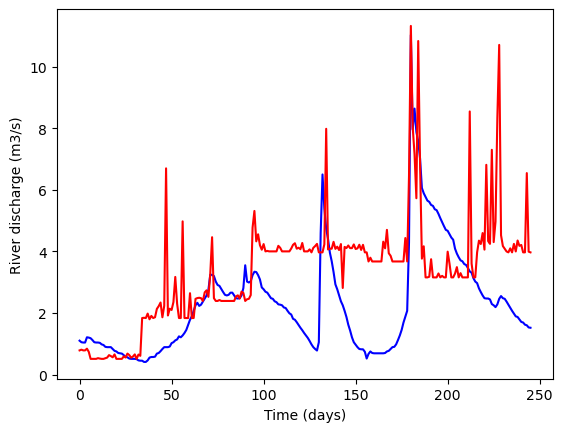



 ----- TESTING FOR RIVER: RD_data/RD_MondegoR_pg.csv ------ 


Best hyper-parameters (alpha, memory1, memory2):  (400, 160)
RMSE training: 14.910006310176817
RMSE test: 22.461481207751085
R2 test: -2.696467215121662


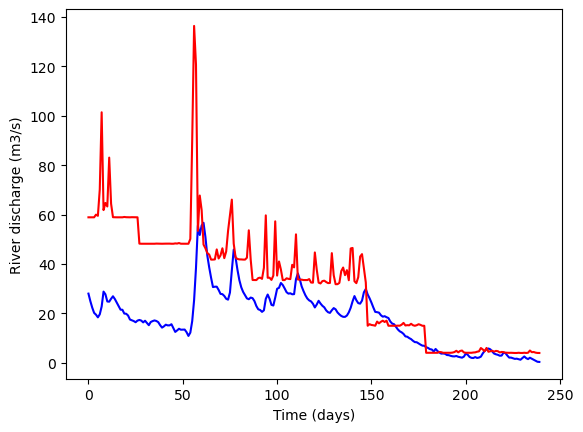



 ----- TESTING FOR RIVER: RD_data/RD_NeivaR_pg.csv ------ 


Best hyper-parameters (alpha, memory1, memory2):  (400, 355)
RMSE training: 0.7024128259663074
RMSE test: 1.2364069692795658
R2 test: -0.3985867615548684


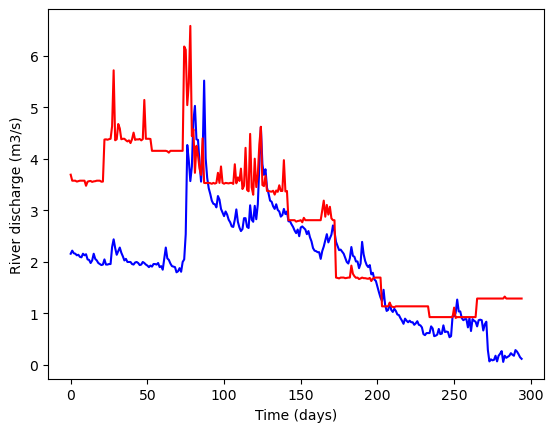



 ----- TESTING FOR RIVER: RD_data/RD_VougaR_pg.csv ------ 


Best hyper-parameters (alpha, memory1, memory2):  (300, 355)
RMSE training: 27.157952341966762
RMSE test: 5.272486905689779
R2 test: 0.08161051131422015


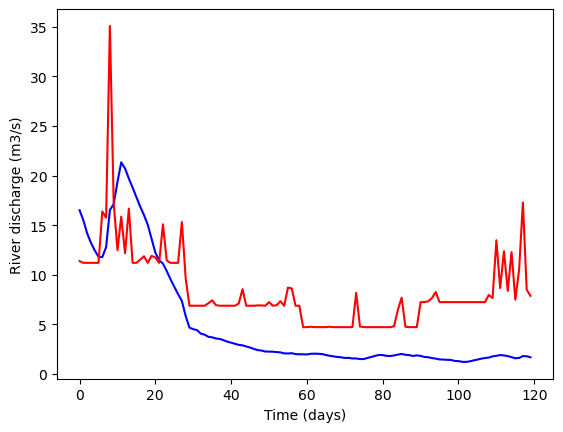

In [14]:
fit_for_river("RD_data/RD_AntuaR_pg.csv")
fit_for_river("RD_data/RD_MondegoR_pg.csv")
fit_for_river("RD_data/RD_NeivaR_pg.csv")
fit_for_river("RD_data/RD_VougaR_pg.csv")